# **$$\text{Model Training with Hyperparameter Tuning}$$**

---

## **$$\text{Introduction and Imports}$$**

Implementing and evaluating multiple regression modeedls by comparing them to identify the most effective model for Uber Price Predictions.
Each model's performance is assessed using relevant metrics and visualizations.

#### Regression Models:
  - Linear Regression
  - Ridge Regression
  - Lasso Regression
  - ElasticNet Regression
  - Decision Tree Regression
  - Random Forest Regression
  - Gradient Boosting Regression

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#model trianing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import pickle

In [4]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..', 'scripts'))
from dataframe_utils import explode_lists

---

## **$$\text{Preparation}$$**

In [5]:
uber = pd.read_csv('../data/processed_data.csv')

In [6]:
uber.head()

,fare_amount,distance_km,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,7.5,1.683,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19
1,7.7,2.458,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20
2,12.9,5.036,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21
3,5.3,1.662,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8
4,16.0,4.475,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17


In [7]:
X = uber.drop(['fare_amount'], axis=1)   #features
y = uber['fare_amount']                  #target variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Function to save results of best tuned model within the results dictionary

In [9]:
results = []

In [8]:
def score_best_model(name: str, best_model: object, X_train: pd.DataFrame = X_train, y_train: pd.DataFrame = y_train):
    '''
    Works out MAE, RMSE, R2 based on best passed model
    '''
    model = best_model

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    #errors
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    result = {
        'model': name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'coefficients': None,
        'feature_importances': None,
        'type': None
    }

    try: #store coef for linear models
        result['coefficients'] = model.coef_.tolist()
        result['type'] = 'linear'
    except AttributeError: #store feature importance for tree models
        result['feature_importances'] = model.feature_importances_.tolist()
        result['type'] = 'tree'
    
    results.append(result)

---

## **$$\text{Linear Regression}$$**

[Linear Regression](https://www.analyticsvidhya.com/blog/2021/10/everything-you-need-to-know-about-linear-regression/): Assumes linear relationship between features (independant variable) and the target value (fare amount), to find the best linear equasion / line, that best minimizes the differences netweem predicted and actual values and described how the input vairables influence the target variables.

#### $$\text{Linear Regression}: Y = a + bX$$

In [10]:
linearModel = LinearRegression()

In [11]:
linearModel.fit(X_train, y_train)

LinearRegression()

In [12]:
pd.DataFrame(linearModel.coef_, index=X.columns, columns=['coefficients']).head(3)

,coefficients
distance_km,2.135120
pickup_longitude,-1.656597
pickup_latitude,8.661578


In [13]:
linear_pred = linearModel.predict(X_test)

<Axes: title={'center': 'Linear Regression Model Prediction'}, xlabel='fare_amount', ylabel='Linear Regression Predictions'>

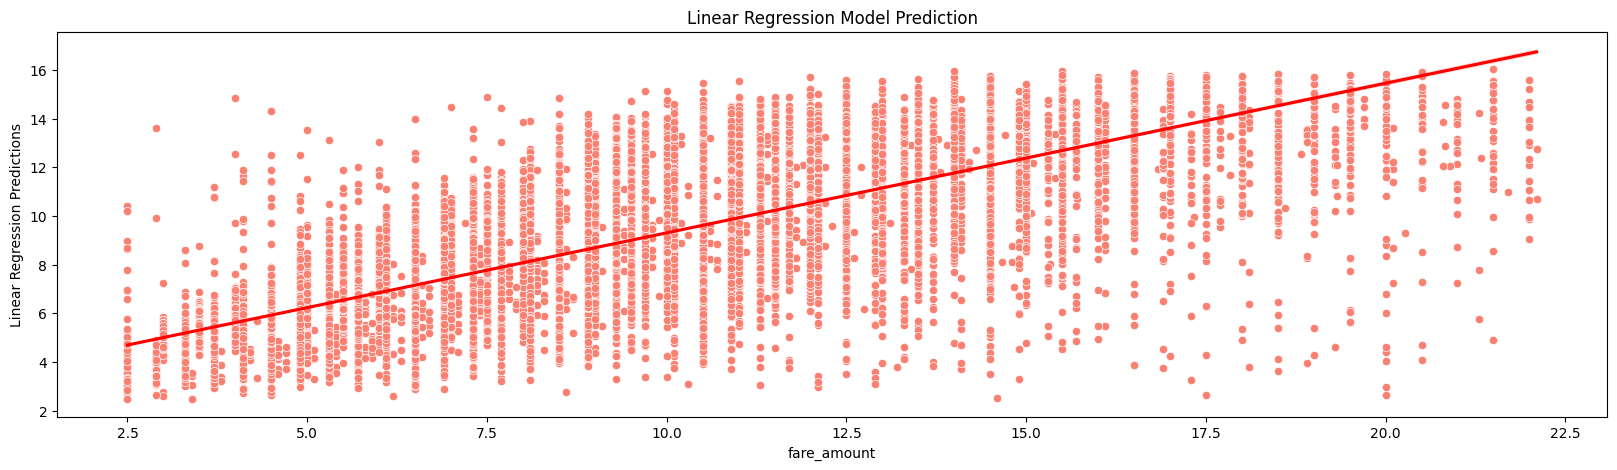

In [24]:
plt.figure(figsize=(20,5))
sns.scatterplot(x=y_test, y=linear_pred, color='salmon')

plt.ylabel('Linear Regression Predictions')
plt.title('Linear Regression Model Prediction')

sns.regplot(x=y_test, y=linear_pred, scatter=False, color='red')

### **$$\text{Model Scoring}$$**

In [14]:
linear_mae = mean_absolute_error(y_test, linear_pred)
print(f'MAE: {linear_mae}')

MAE: 1.471796834896026


##### **$$\text{Mean Absolute Error: 1.482}$$**

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$


In [15]:
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
print(f'RMSE: {linear_rmse}')

RMSE: 2.0628528362506096


##### **$$\text{Root Mean Squared Error: 2.086}$$**

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [16]:
linear_r2 = r2_score(y_test, linear_pred) #no need for negation
print(f'R2: {linear_r2}')

R2: 0.6155968775648837


##### **$$\text{R-squared: 0.611}$$**

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

In [17]:
score_best_model('linear', linearModel)

---

## **$$\text{Ridge Regression}$$**

[Ridge Regression](https://www.analyticsvidhya.com/blog/2021/10/everything-you-need-to-know-about-linear-regression/): Regulization techniuque adding penalty term (L2 penalty) to linear regression model to shrink coefficient values. The L2 penalty (adds sum of summed coefficient values multiplied by a turning parameter (lambda)), it discoureges lerge coefficient values, pushing them towards zero. Shrinking the less important features impact so they affect model less.

$$\text{Lasso Formula} = L = \sum( \hat{y}_i– y_i)^2 + \lambda \sum|\beta|^2

$$\text{Ridge Cost Function} = \sum( \hat{y}_i– y_i)^2 + \lambda \cdot \sum||w||^2$$

$$\sum( \hat{y}_i– y_i)^2 = \text{Sum of squared residuals}$$
$$\lambda = \text{penalty for errors}$$
$$\text{w = slope of curve or line}

Hyperparameter tuning, to find the best normalization parameter $\lambda$ ($\alpha$)

In [18]:
hyperparameters = {'alpha': [1e-10,1e-5,1e-3,1e-2,1,5,10,25,50,100,]}

ridgeModel = Ridge()
ridge_grid = GridSearchCV(ridgeModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error', 
                              verbose=1,
                              n_jobs=-1) #cv 5

ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-05, 0.001, 0.01, 1, 5, 10, 25, 50,
                                   100]},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=1)

In [19]:
print(f'Best alpha value                      : {ridge_grid.best_params_['alpha']}')
print(f'Best negative root mean squared error : {ridge_grid.best_score_}')

Best alpha value                      : 1
Best negative root mean squared error : -1.4888694665007887


In [20]:
ridge_best = ridge_grid.best_estimator_
score_best_model('rige', ridge_best)

---

## **$$\text{Lasso Regression}$$**

[Lasso Regression](https://www.analyticsvidhya.com/blog/2021/10/everything-you-need-to-know-about-linear-regression/): Also known as Least Attribute Shrinkage and Selection Operator, it's a regularisaion method that also includes penalty but sets some coefficients to 0, essentially selecting which elements matter. It uses L1 penalty (sum of absolute values of the coefficients multiplied by lambda)

$$\text{Lasso Cost Function} = \sum( \hat{y}_i– y_i)^2 + \lambda \cdot \sum||w||$$


In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
hyperparameters = {'alpha': [1e-10,1e-5,1e-3,1e-2,1,5,10,25]}

lassoModel = Lasso(max_iter=1000)
lasso_grid = GridSearchCV(lassoModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error',
                              verbose=3,
                              n_jobs=-1)
lasso_grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-05, 0.001, 0.01, 1, 5, 10, 25]},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=3)

In [23]:
print(f'Best alpha value                      : {lasso_grid.best_params_['alpha']}')
print(f'Best negative root mean squared error : {lasso_grid.best_score_}')

Best alpha value                      : 1e-05
Best negative root mean squared error : -1.492417124285202


In [24]:
lasso_best = lasso_grid.best_estimator_
score_best_model('lasso', lasso_best)

---

## **$$\text{Elastic Net Regression}$$**

$$\text{Elastic Net Cost Function} = \sum( \hat{y}_i– y_i)^2 + \lambda \sum w^2 + \lambda \sum ||w||^2

[Elasticnet Regression](https://www.analyticsvidhya.com/blog/tag/elasticnet-regression/): Combines  penlaties of both Ridge (L2) and Lasso (L1) regressions in order to use the streghts of both of the methods. However this subjects the coefficients to two types of shrinkages, causing low efficiency in predictability and high bias. This is corrected the coefficients are rescaled by multiplying by $(1+\lambda_2)$

In [25]:
hyperparameters = {'alpha': [1e-10,1e-5,1e-3,1e-2,1],
                   'l1_ratio': np.linspace(0.111,0.999,5)}

elasticModel = ElasticNet()
elastic_grid = GridSearchCV(elasticModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error',
                              verbose=1,
                              n_jobs=-1)
elastic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-05, 0.001, 0.01, 1],
                         'l1_ratio': array([0.111, 0.333, 0.555, 0.777, 0.999])},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=1)

In [26]:
print(f'Best alpha value                      : {elastic_grid.best_params_['alpha']}')
print(f'Best l1 ratio value                   : {elastic_grid.best_params_['l1_ratio']}')
print(f'Best negative root mean squared error : {elastic_grid.best_score_}')

Best alpha value                      : 1e-05
Best l1 ratio value                   : 0.999
Best negative root mean squared error : -1.4924171255846705


In [27]:
elastic_best = elastic_grid.best_estimator_
score_best_model('elastic', elastic_best)

-----

## **$$\text{Decision Tree Regressor}$$**

[Decision Tree Regressor](): Non-linear regression model that recursively splits the data into subsets based on the most significant feature at each node / split. They have a high variance, as different splits can lead to very different results.


In [28]:
hyperparameters = {
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
}


dtreeModel = DecisionTreeRegressor()
dtree_grid = GridSearchCV(dtreeModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error',
                              verbose=1,
                              n_jobs=-1)
dtree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'splitter': ['best', 'random']},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=1)

In [29]:
print(f'Best max_depth                        : {dtree_grid.best_params_['max_depth']}')
print(f'Best min_samples_split                : {dtree_grid.best_params_['min_samples_split']}')
print(f'Best min_samples_leaf                 : {dtree_grid.best_params_['min_samples_leaf']}')
print(f'Best negative root mean squared error : {dtree_grid.best_score_}')

Best max_depth                        : 10
Best min_samples_split                : 2
Best min_samples_leaf                 : 15
Best negative root mean squared error : -1.3935020434858565


In [30]:
dtree_best = dtree_grid.best_estimator_
score_best_model('dtree', dtree_best, X_train, y_train)

---

## **$$\text{Random Forest Regression}$$**

[Random Forest Regressor](): An ensammble learning method that constructs multiple decision trees during training and outputs average prediction. Uses bootstrap, sampling with replacement. This is so that they dont all split using the same feature as the top split, in which case it'd create an ensable of highly corelated trees

In [31]:
hyperparameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10],
    'min_samples_split': [1, 2, 10],
    'min_samples_leaf': [1, 5],
    'bootstrap': [True],
}

rforestModel = RandomForestRegressor()
rforest_grid = GridSearchCV(rforestModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error',
                              verbose=1,
                              n_jobs=-1)
rforest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None, 10],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [1, 2, 10],
                         'n_estimators': [100, 150, 200]},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=1)

In [32]:
print(f'Best n_estimators                     : {rforest_grid.best_params_['n_estimators']}')
print(f'Best max_depth                        : {rforest_grid.best_params_['max_depth']}')
print(f'Best min_samples_split                : {rforest_grid.best_params_['min_samples_split']}')
print(f'Best min_samples_leaf                 : {rforest_grid.best_params_['min_samples_leaf']}')
print(f'Best bootstrap                        : {rforest_grid.best_params_['bootstrap']}')
print(f'Best negative root mean squared error : {rforest_grid.best_score_}')

Best n_estimators                     : 200
Best max_depth                        : None
Best min_samples_split                : 2
Best min_samples_leaf                 : 5
Best bootstrap                        : True
Best negative root mean squared error : -1.2840351901691445


In [33]:
rforest_best = rforest_grid.best_estimator_
score_best_model('rforest', rforest_best)

---

## **$$\text{Gradient Boosting Regressor}$$**

[Gradient Boosting Regressor](): Ensamble technique that builds sequence of trees, where each tree corrects errors of its predecessor. It fits new models to provide more accurate estimate of response variable. Improves the model sequentially.

In [34]:
hyperparameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 5],
}


gboostingModel = GradientBoostingRegressor()
gboosting_grid = GridSearchCV(gboostingModel, hyperparameters, 
                              scoring='neg_mean_absolute_error', 
                              refit='neg_root_mean_squared_error',
                              verbose=1,
                              n_jobs=-1)
gboosting_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 10],
                         'min_samples_leaf': [1, 5], 'min_samples_split': [2],
                         'n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error',
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
print(f'Best n_estimators                     : {gboosting_grid.best_params_['n_estimators']}')
print(f'Best learning_rate                    : {gboosting_grid.best_params_['learning_rate']}')
print(f'Best max_depth                        : {gboosting_grid.best_params_['max_depth']}')
print(f'Best min_samples_split                : {gboosting_grid.best_params_['min_samples_split']}')
print(f'Best min_samples_leaf                 : {gboosting_grid.best_params_['min_samples_leaf']}')
print(f'Best negative root mean squared error : {gboosting_grid.best_score_}')

Best n_estimators                     : 200
Best learning_rate                    : 0.1
Best max_depth                        : 10
Best min_samples_split                : 2
Best min_samples_leaf                 : 5
Best negative root mean squared error : -1.1988349598811487


In [36]:
gtree_best = gboosting_grid.best_estimator_
score_best_model('gboosting', gtree_best)

---

# $$\text{MODEL ANALYSIS}$$

## $$\text{Data Overview}$$

In [37]:
results_df = pd.DataFrame(results)
results_df['columns'] = [X_test.columns.tolist()] * len(results_df)

In [38]:
linear = results_df[results_df['type'] == 'linear']
tree = results_df[results_df['type'] == 'tree']

In [41]:
linear_exp = explode_lists(linear, 'columns', 'coefficients', results_df['model'])
tree_exp = explode_lists(tree, 'columns', 'feature_importances', results_df['model'])

In [42]:
linear_exp.head(2)

,label,columns,coefficients
0,linear,distance_km,2.135120
1,linear,pickup_longitude,-1.656597


In [43]:
tree_exp.head(2)

,label,columns,feature_importances
0,dtree,distance_km,0.846068
1,dtree,pickup_longitude,0.003996


---

## $$\text{Results Visualization}$$

In [190]:
sns.set_theme(style='darkgrid', font='DejaVu Sans')

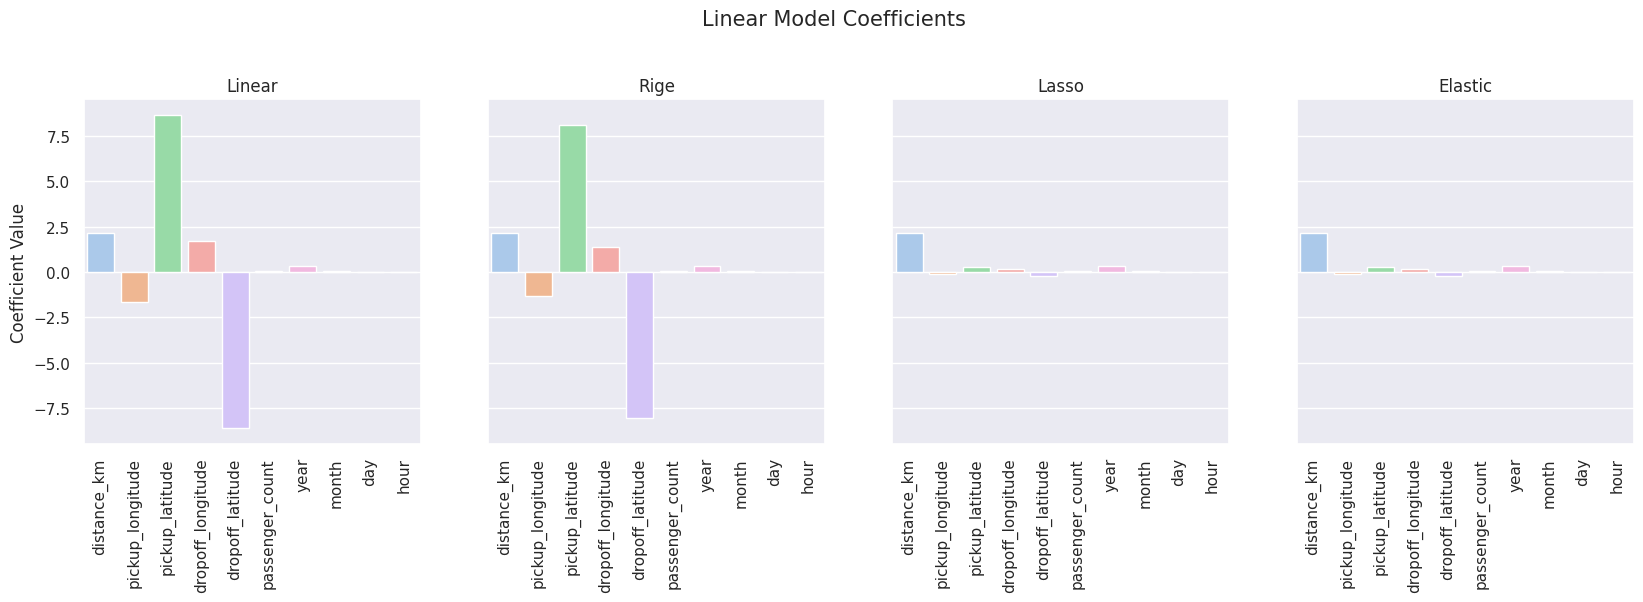

In [191]:
fig, ax = plt.subplots(ncols=linear_exp['label'].nunique(), figsize=(20,5), sharey=True, sharex=True)


linears_models = linear_exp['label'].unique()

for i,j in enumerate(linears_models):
    sns.barplot(ax=ax[i], data=linear_exp[linear_exp['label'] == j], x='columns', y='coefficients', palette='pastel', ci=None)
    ax[i].set_title(j.title())
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylabel('Coefficient Value')
    ax[i].set_xlabel('')
    
fig.suptitle('Linear Model Coefficients', size=15)
fig.subplots_adjust(top=0.8)

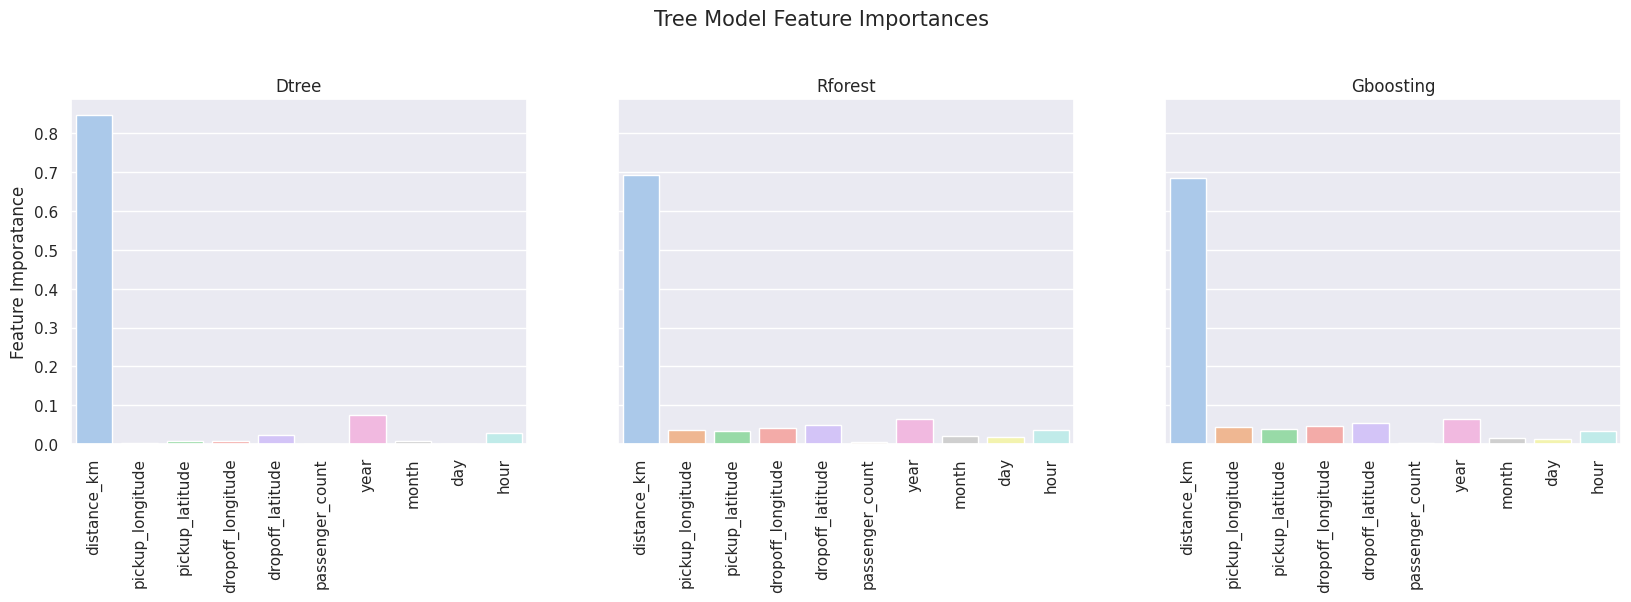

In [230]:
fig, ax = plt.subplots(ncols=tree_exp['label'].nunique(), figsize=(20,5), sharey=True, sharex=True)


tree_models = tree_exp['label'].unique()

for i,j in enumerate(tree_models):
    sns.barplot(ax=ax[i], data=tree_exp[tree_exp['label'] == j], x='columns', y='feature_importances', palette='pastel', ci=None)
    ax[i].set_title(j.title())

    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylabel('Feature Imporatance')
    ax[i].set_xlabel('')

fig.suptitle('Tree Model Feature Importances', size=15)
fig.subplots_adjust(top=0.8)

In [ ]:
results_df

,model,mae,rmse,r2,coefficients,feature_importances,type,columns
0,linear,1.471797,2.062853,0.615597,"[2.1351200405627124, -1.656596862244109, 8.661...",None,linear,"[distance_km, pickup_longitude, pickup_latitud..."
1,rige,1.471796,2.062854,0.615597,"[2.13512362331247, -1.6525006849093553, 8.6554...",None,linear,"[distance_km, pickup_longitude, pickup_latitud..."
2,lasso,1.476013,2.069442,0.613137,"[2.1365804807302564, -0.08465858055131874, 0.2...",None,linear,"[distance_km, pickup_longitude, pickup_latitud..."
3,elastic,1.476013,2.069442,0.613137,"[2.13658047065338, -0.08466061354918662, 0.256...",None,linear,"[distance_km, pickup_longitude, pickup_latitud..."
4,dtree,1.378171,1.960200,0.652903,None,"[0.8460607018847083, 0.0039083858045492045, 0....",tree,"[distance_km, pickup_longitude, pickup_latitud..."
5,rforest,1.261670,1.822428,0.699979,None,"[0.6924779814109275, 0.03739104466456945, 0.03...",tree,"[distance_km, pickup_longitude, pickup_latitud..."
6,gboosting,1.172631,1.730974,0.729335,None,"[0.685346669529878, 0.04400661811317187, 0.039...",tree,"[distance_km, pickup_longitude, pickup_latitud..."


In [214]:
melted_results = pd.melt(results_df, id_vars='model', value_vars=['mae', 'rmse', 'r2'])

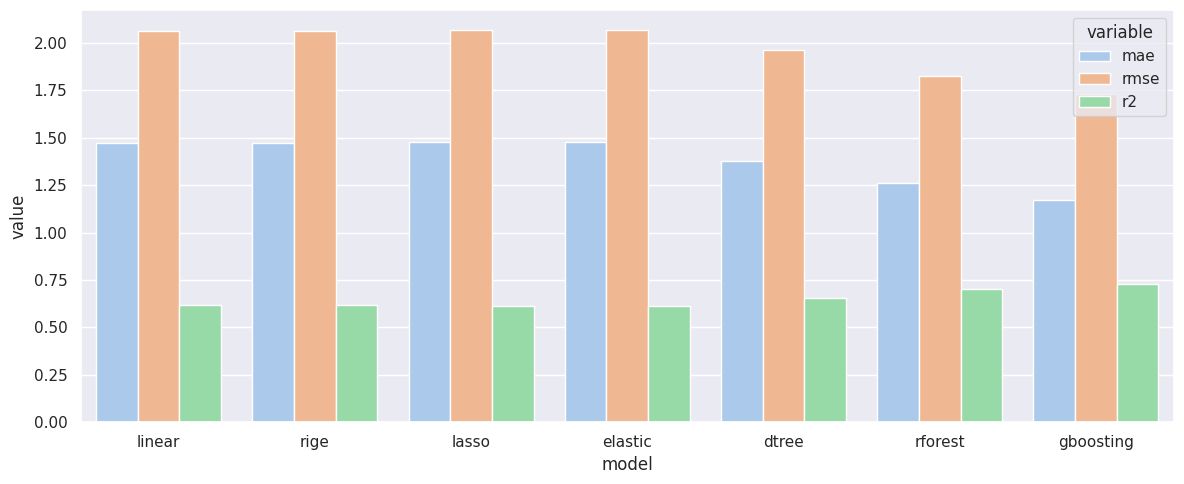

In [231]:
plt.figure(figsize=(12, 5))
sns.barplot(x='model', y='value', hue='variable', data=melted_results, palette='pastel')
plt.tight_layout()

### $$ \text{Gradient Boosting Model has lowest error metrics thus being the best model}$$

---

## $$\text{Model Saving}$$

In [ ]:
with open('../model/trained_model.pkl','wb') as f:
    pickle.dump(gboostingModel, f)

---